House Price Prediction EDA (updated 2019.03.12)    
https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12
을 참고하여 예측을 수행했습니다.
1. 집의 정보를 가지고 가격을 예측하는 회귀문제
2. 평가 지표 : RMSE

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np

random_state = 42

data_file = './data'
train_data = data_file + '/train.csv'
test_data = data_file + '/test.csv'

train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

In [2]:
print('train.csv :', train_df.shape)
print('test.csv: ', test_df.shape)

train.csv : (15035, 21)
test.csv:  (6468, 20)


train, test 데이터셋의 크기는 15000, 6500 정도로 작은 편이고 5:2 정도로 크게 불균등한 편은 아닙니다.   
feature의 개수가 20개로, 적은 편이어서 feature engineering을 잘 하는 것이 좋겠다는 생각이 듭니다.

In [3]:
train_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

- 결측치는 보이지 않음
- date -> yyyymmdd + T0000000 (이부분 제거할 예정)   
- bathrooms의 경우 소숫점의 값이 보이는데, 이는 미국의 기준에 따른 것입니다. 자세한 내용은 아래 부분에 나옵니다.
- floors의 경우 소숫점의 값이 보임.  
- lat, long 은 위도와 경도이므로 소수점으로 나타나는 건 당연해보임

In [5]:
# id 제거 및 date, yr_renocate 변환
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)
train_df['date'] = train_df['date'].apply(lambda i: i[:6]).astype(int)
test_df['date'] = test_df['date'].apply(lambda i: i[:6]).astype(int)
train_df['yr_renovated'] = train_df['yr_renovated'].apply(
    lambda x: np.nan if x == 0 else x)
train_df['yr_renovated'] = train_df['yr_renovated'].fillna(
    train_df['yr_built'])
test_df['yr_renovated'] = test_df['yr_renovated'].apply(
    lambda x: np.nan if x == 0 else x)
test_df['yr_renovated'] = test_df['yr_renovated'].fillna(test_df['yr_built'])

특성 시각화

목적변수 price의 경우 집을 구매한 시점 의 가격입니다. 이 말은 현재의 가격을 반영하는게 아니라는 말과 같습니다. 집을 산 이후 리모델링을 통해 집을 고쳤어도 집의 가격에는 영향을 주지 못합니다.

In [6]:
train_df['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Density'>

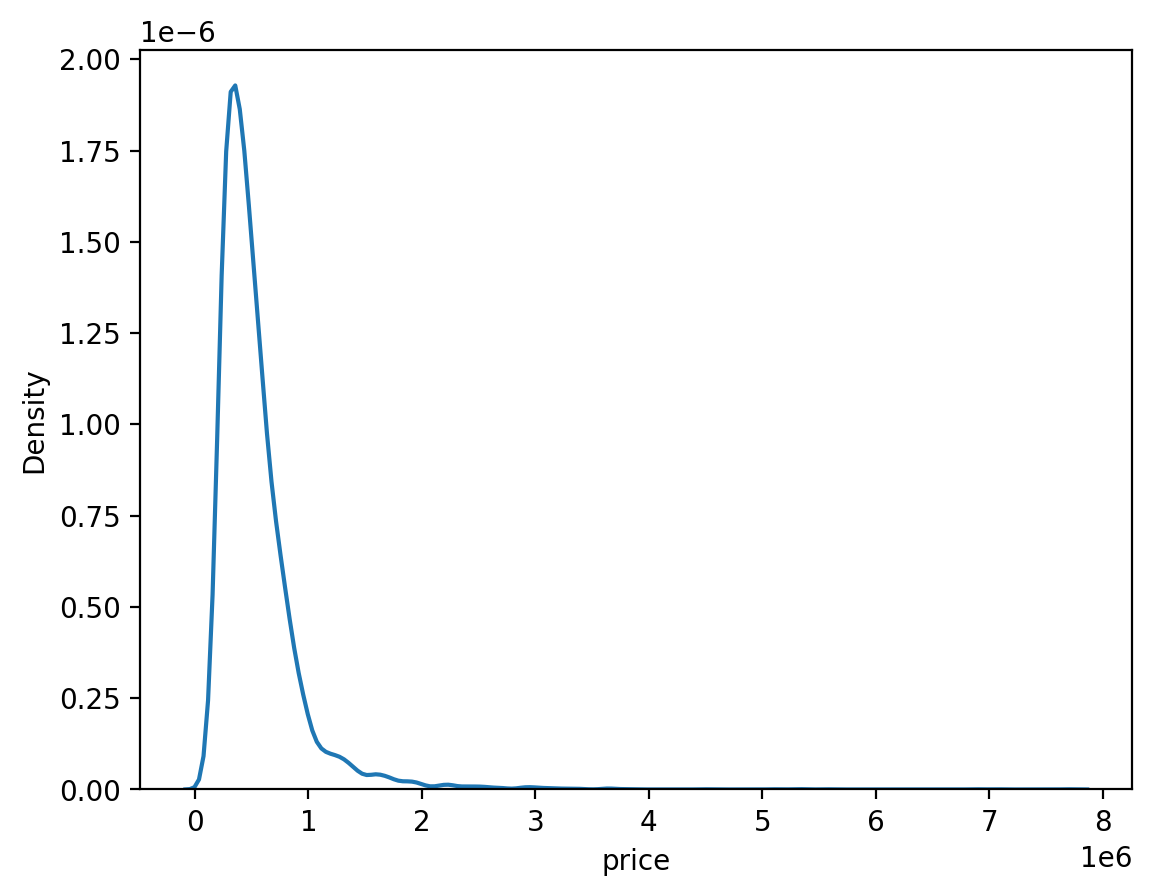

In [7]:
sns.kdeplot(train_df['price'])

목적 변수 price의 경우 min, max 차이가 크고 std가 큰 편임.
또한 왼쪽으로 분포가 굉장히 치우져있음을 알 수 있음  
회귀 모델을 사용할 예정이기 때문에 치우져져있는 분포를 정규분포로 바꿔주겠습니다.

In [8]:
train_df['price'] = np.log1p(train_df['price'])

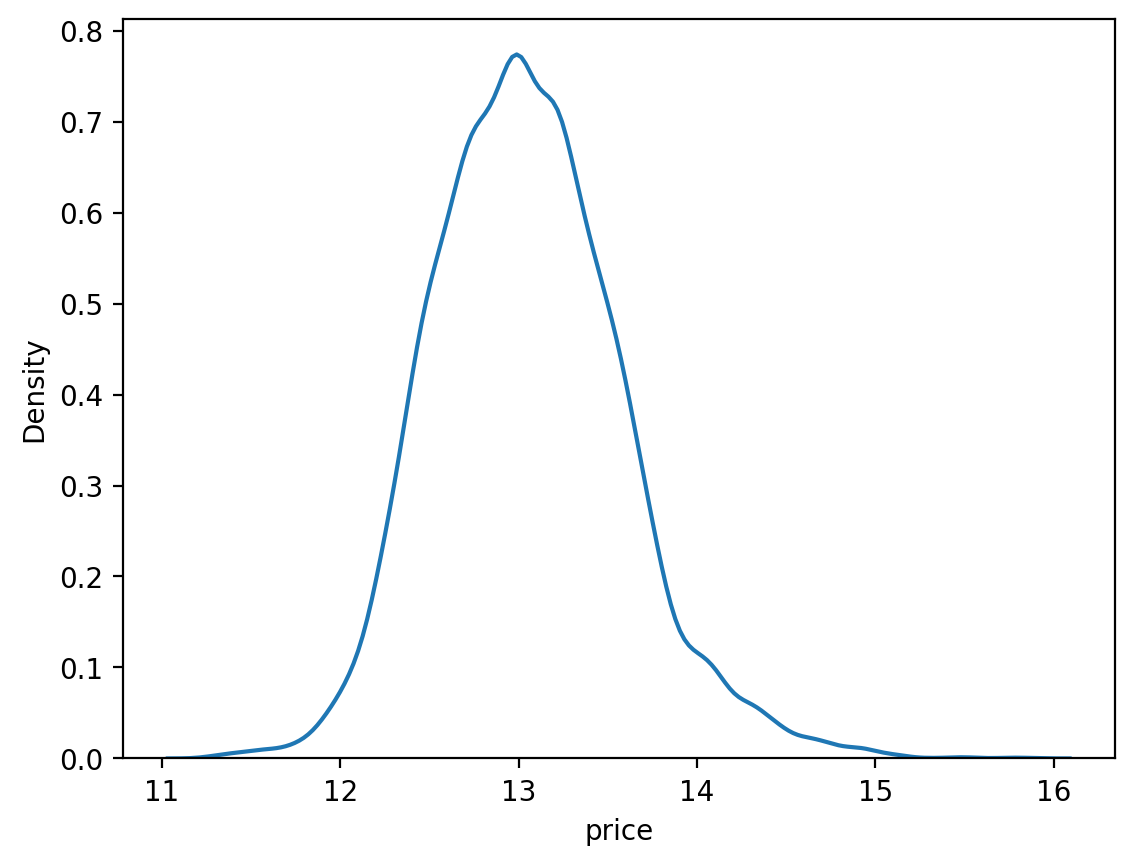

In [9]:
sns.kdeplot(train_df['price'])
plt.show()

변수들의 상관관계 확인

피어슨 상관관계 : 연속형 변수에 사용   
스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<Axes: >

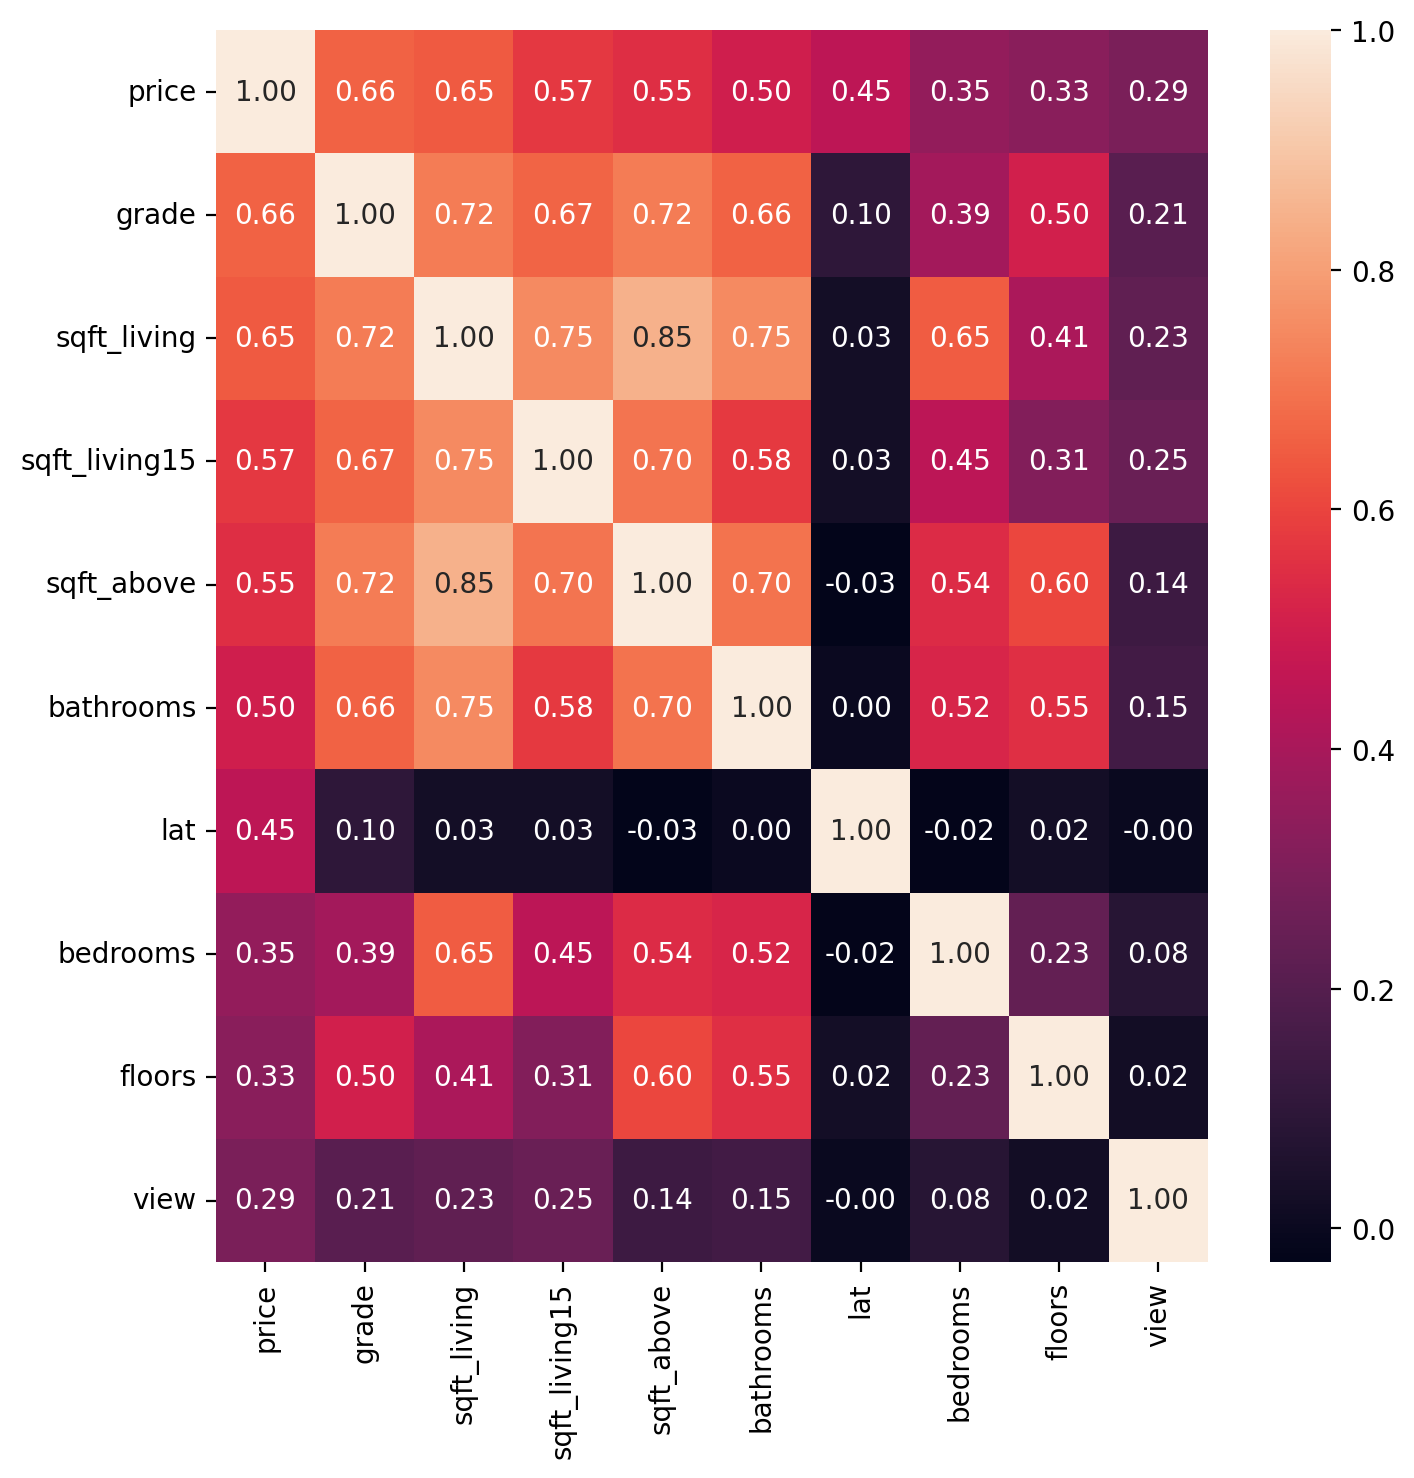

In [10]:
import scipy as sp
cor_abs = abs(train_df.corr(method='spearman'))
# price와 corr이 col 10개 추출
cor_cols = cor_abs.nlargest(n=10, columns='price').index
cor = np.array(sp.stats.spearmanr(train_df[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(8, 8))
sns.heatmap(cor, annot=True, fmt='.2f',
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)

price와 상관관계가 높은 변수들은 grade, sqft_living, sqft_above 순...    
lat의 경우 price와 상고나관계가 Discussion에 따르면, 위의 지역은 시애틀인데 시애틀은 북쪽으로 갈 수록 살기 좋은 집들이 많다고 합니다.

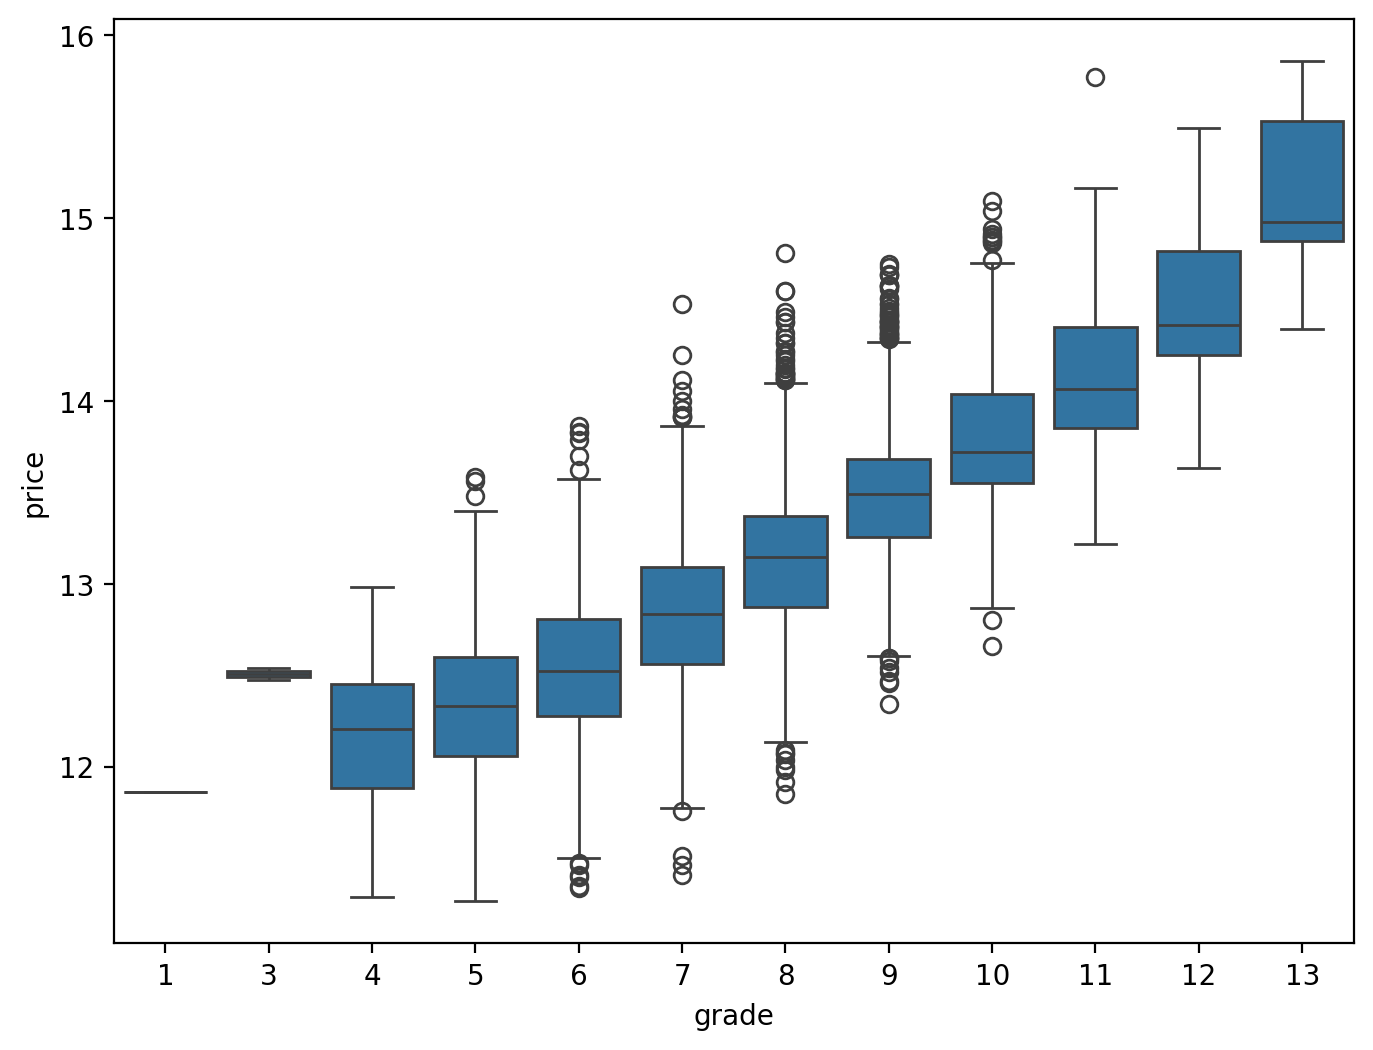

In [11]:
data = pd.concat([train_df['price'], train_df['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

grade의 경우 "1-3은 하자 있는 건물, 7은 평균 수준의 건축디자인, 11-13은 높은 수준"이라고 합니다.   
- 등급 3에서 높은 이유?
- 6,7,8,9,10 에서 낮은 가격이 있는 이유?

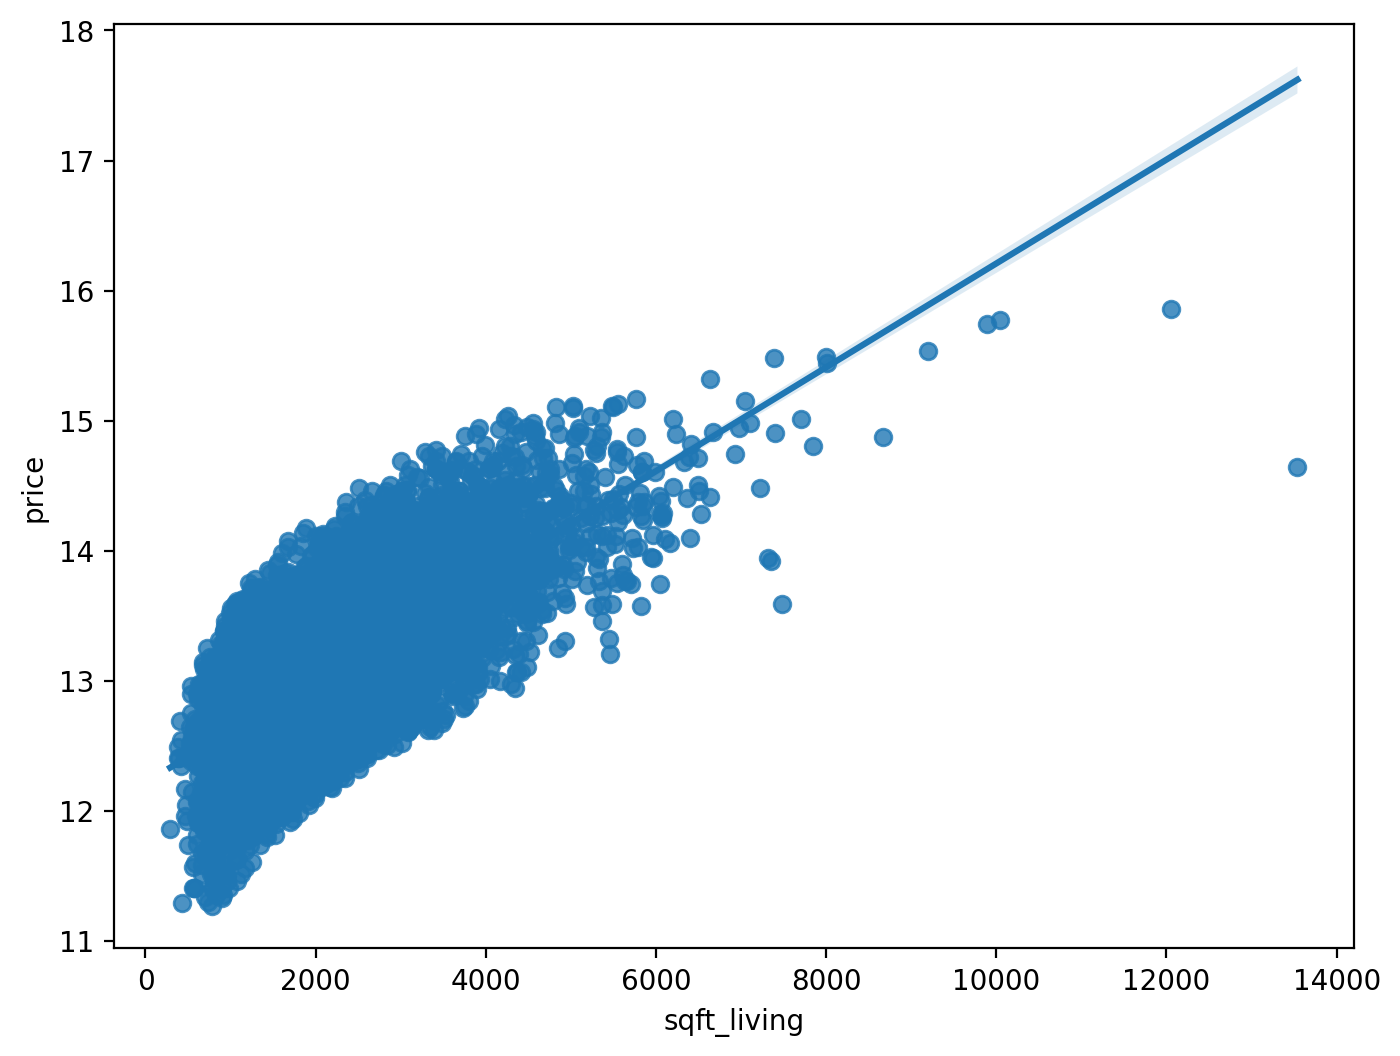

In [12]:
data = pd.concat([train_df['price'], train_df['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

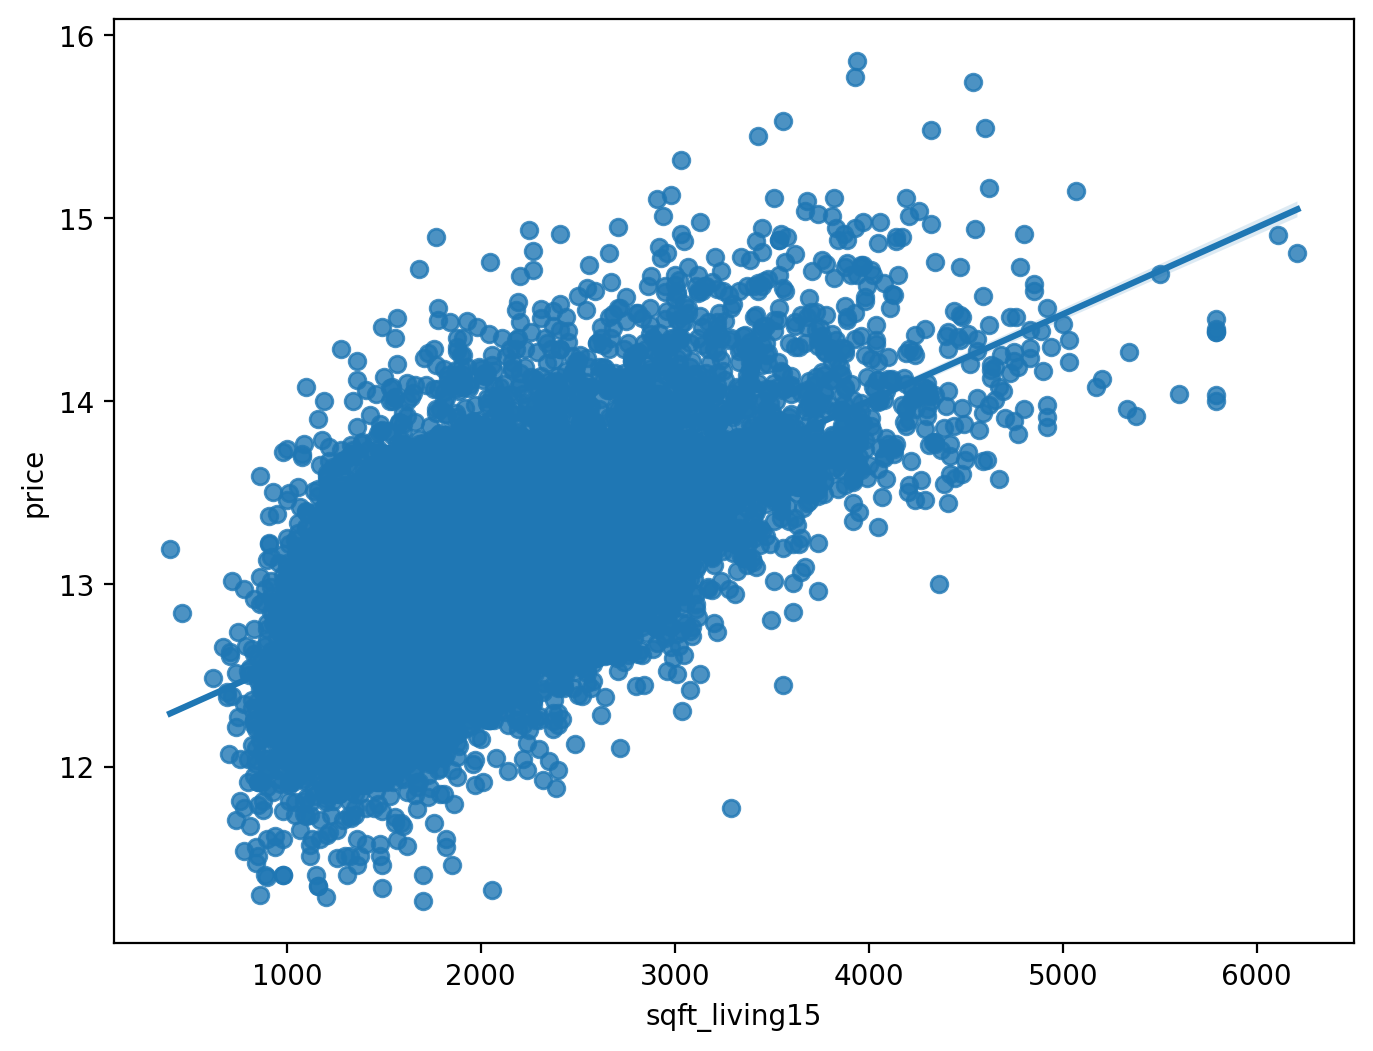

In [13]:
data = pd.concat([train_df['price'], train_df['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

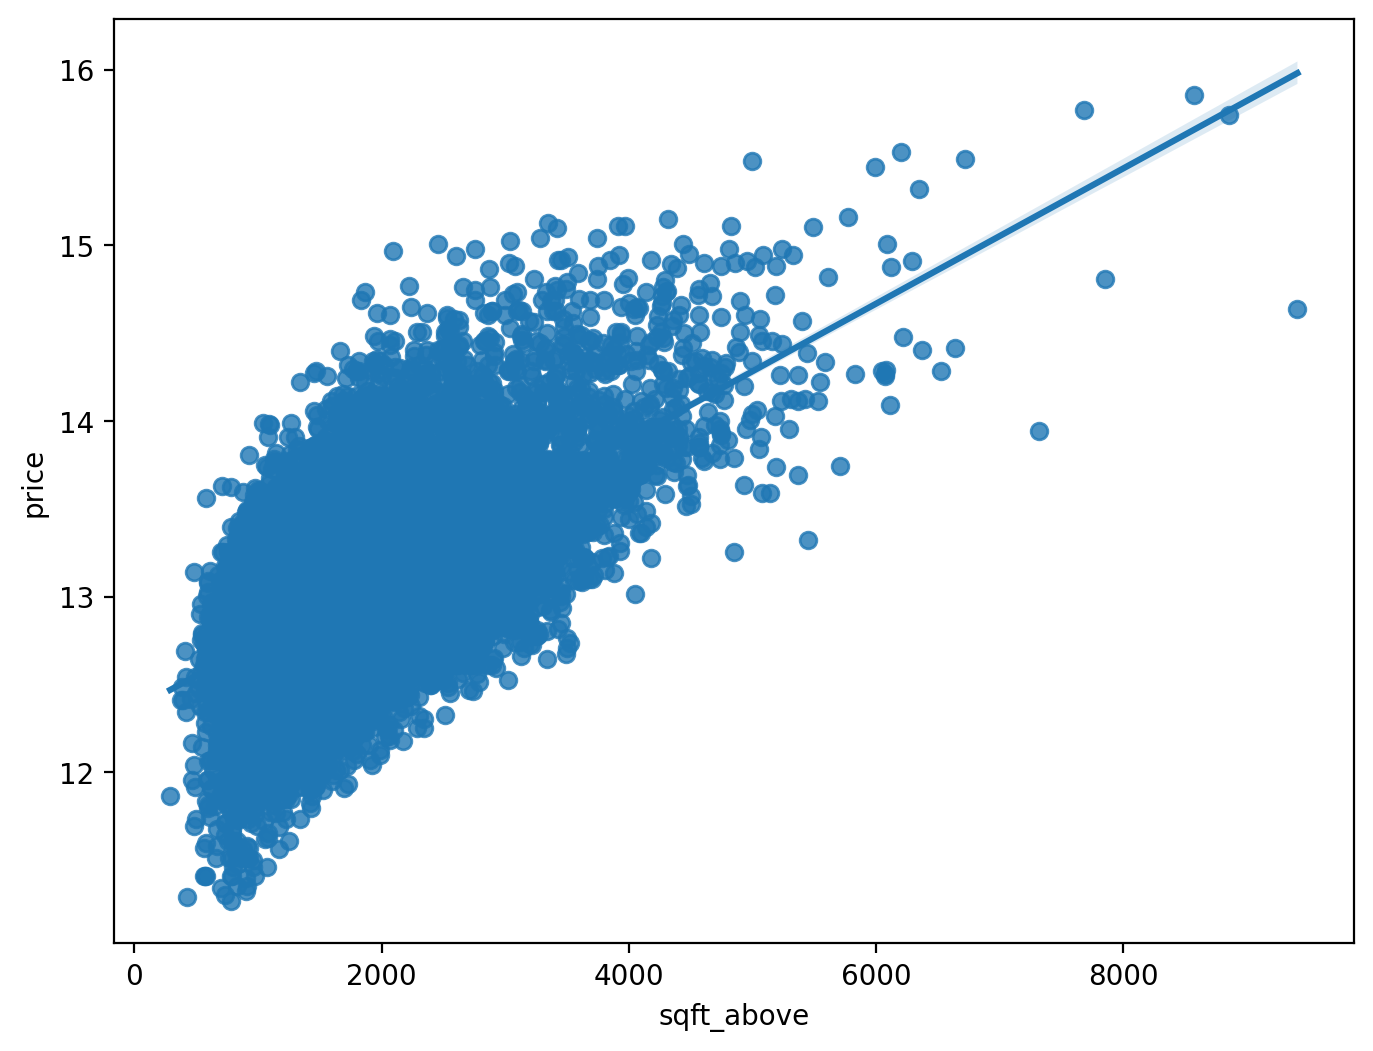

In [14]:
data = pd.concat([train_df['price'], train_df['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

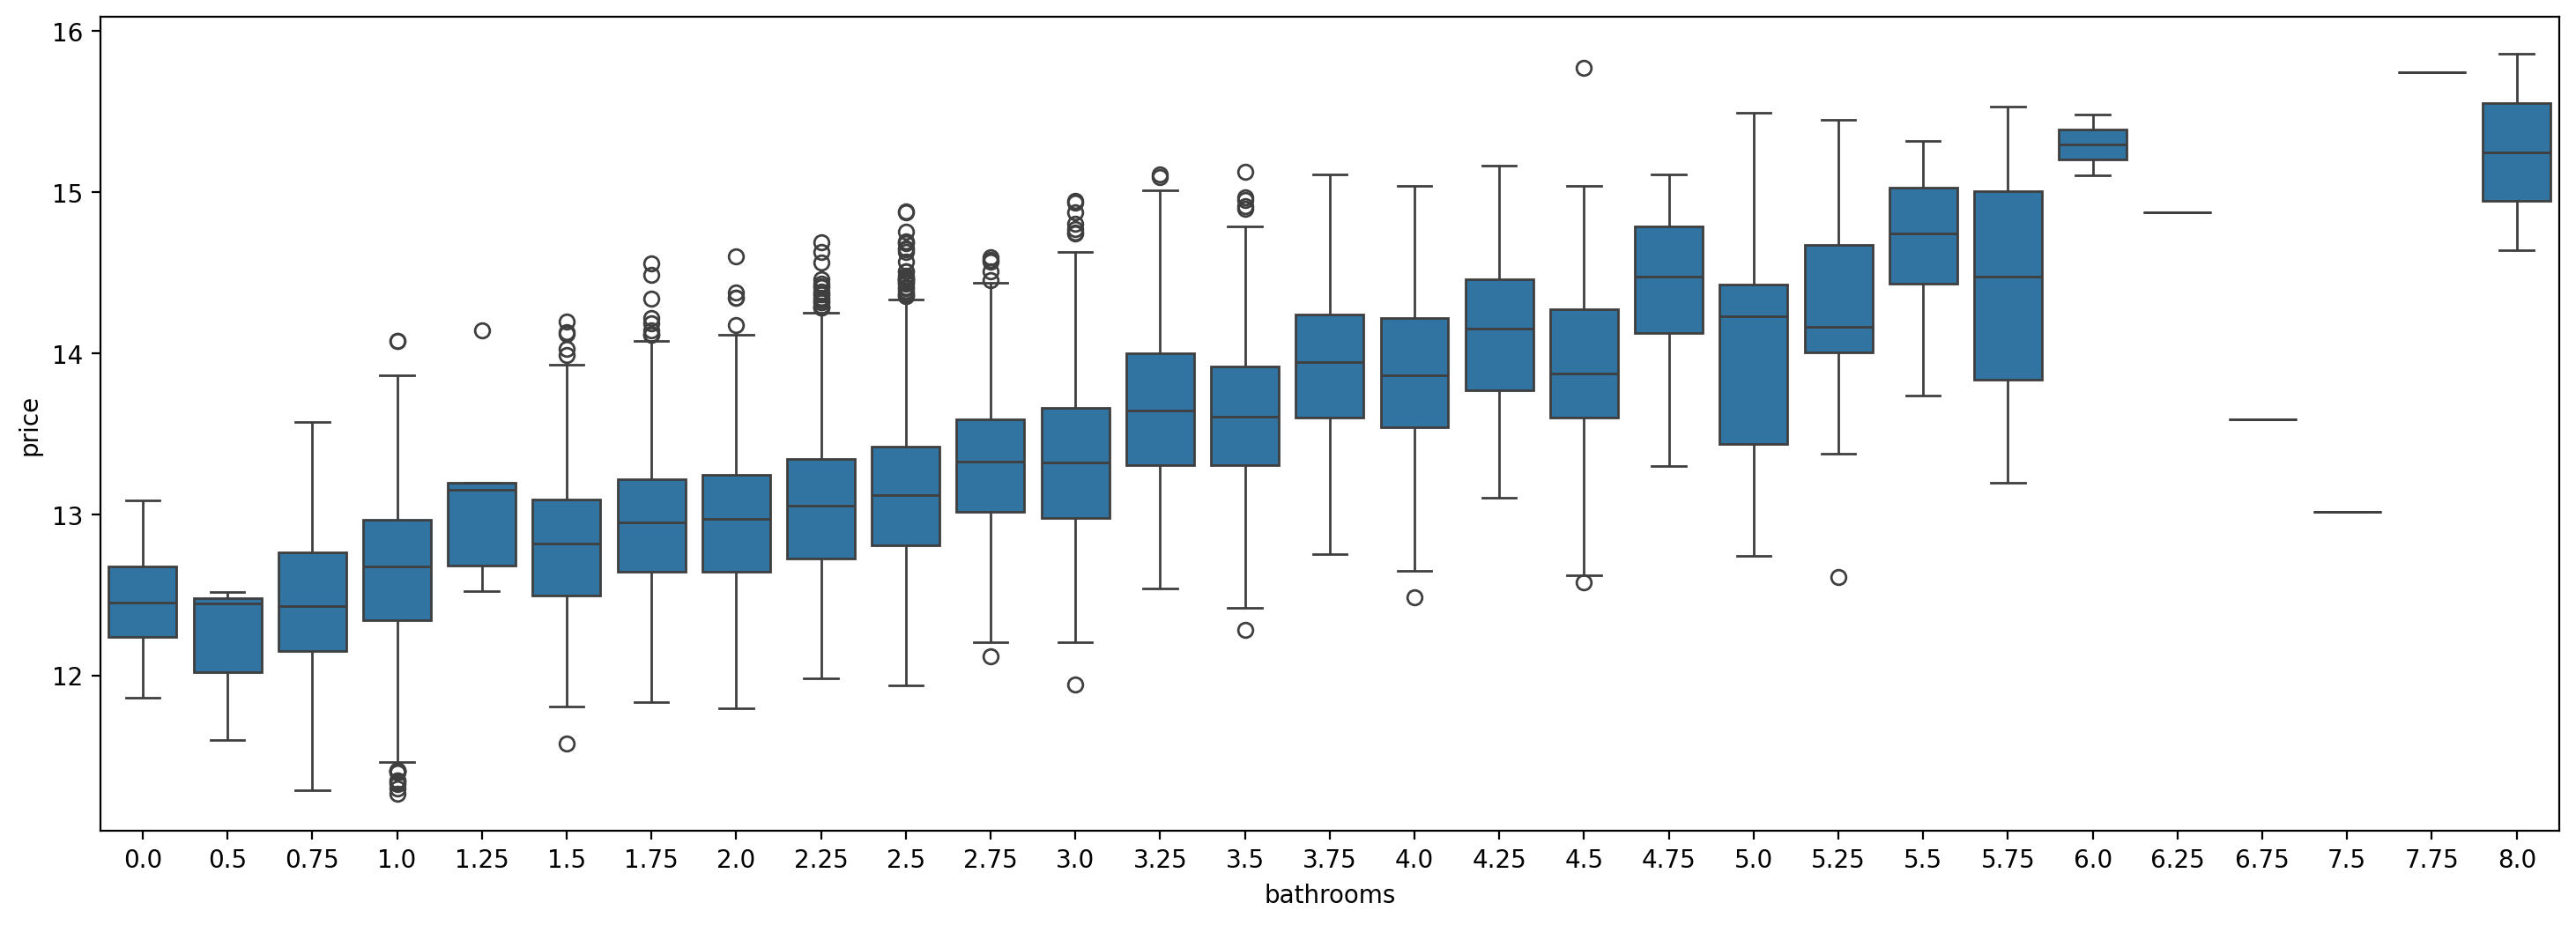

In [15]:
data = pd.concat([train_df['price'], train_df['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

bathrooms같은경우 소숫점이 있어서 많이 헷갈릴 수 있습니다. 각각의 값이 의미하는것은 아래와 같고 위의 값만을 가지고 각각의 값이 몇개있는지는 구분하기 힘들어 보입니다.

- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

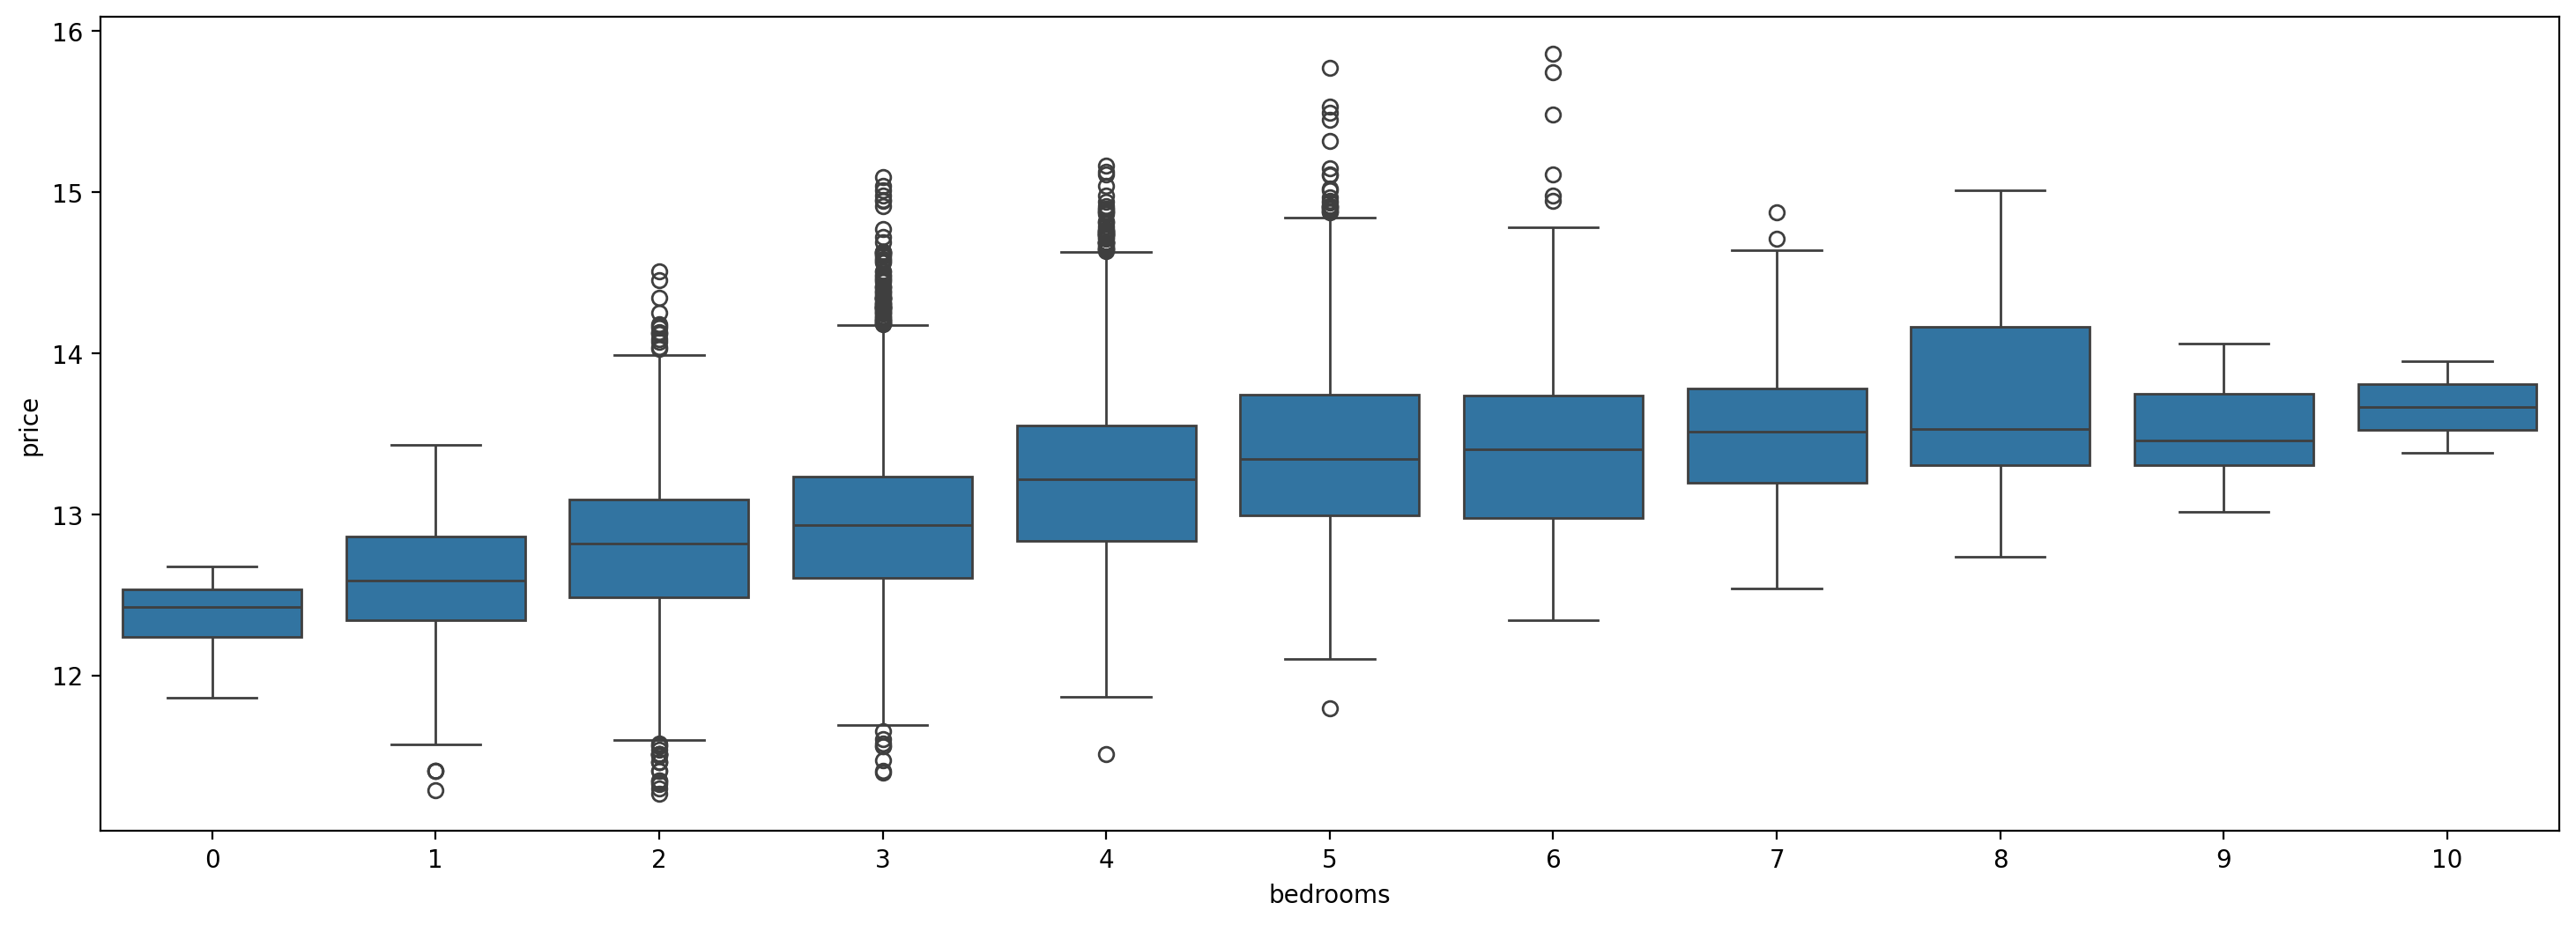

In [16]:
data = pd.concat([train_df['price'], train_df['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

방의 개수가 작아도 높은 가격이 있는 이유는 비싼 부지의 지역일 것 같음

In [17]:
# 수치형 자료의 nuique한 개수 찾기
columns = ['bedrooms', 'bathrooms','floors','waterfront','view','condition','grade']
train_df[columns].nunique()

bedrooms      11
bathrooms     29
floors         6
waterfront     2
view           5
condition      5
grade         12
dtype: int64

In [18]:
for i in columns:
    print(f'{i}: {train_df[i].unique()}')

bedrooms: [ 3  2  5  4  6  1  7  9  8  0 10]
bathrooms: [1.   2.   2.25 1.5  2.5  1.75 3.   2.75 3.25 4.   3.5  0.75 4.75 5.
 4.25 4.5  3.75 5.25 6.   1.25 0.5  5.5  6.75 5.75 0.   8.   7.5  7.75
 6.25]
floors: [1.  2.  1.5 3.  2.5 3.5]
waterfront: [0 1]
view: [0 3 4 2 1]
condition: [3 4 5 2 1]
grade: [ 7  6  8  9 10 11 12  5  4  3 13  1]


이제 이상치 제거를 수행해보겠습니다!

- sqft_living, grade

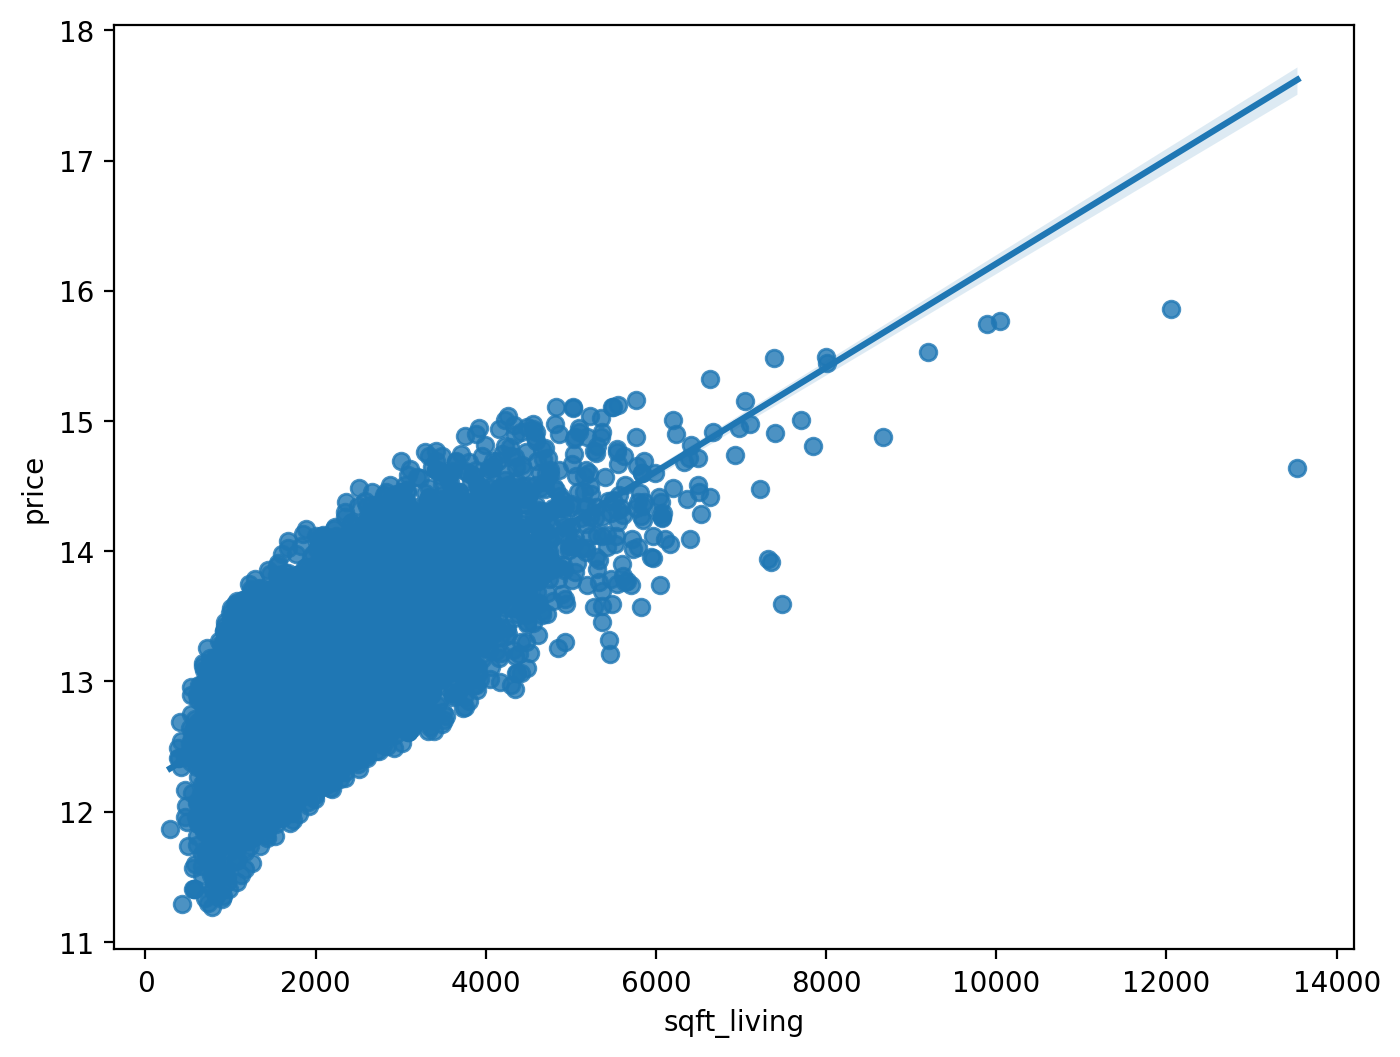

In [19]:
data = pd.concat([train_df['price'], train_df['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [20]:
train_df.loc[train_df['sqft_living'] > 13000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,1999.0,98053,47.6675,-121.986,4850,217800


In [21]:
# 면적이 너무 커서 가격이 높은 듯??? grade
train_df.drop(8912, axis=0, inplace=True)

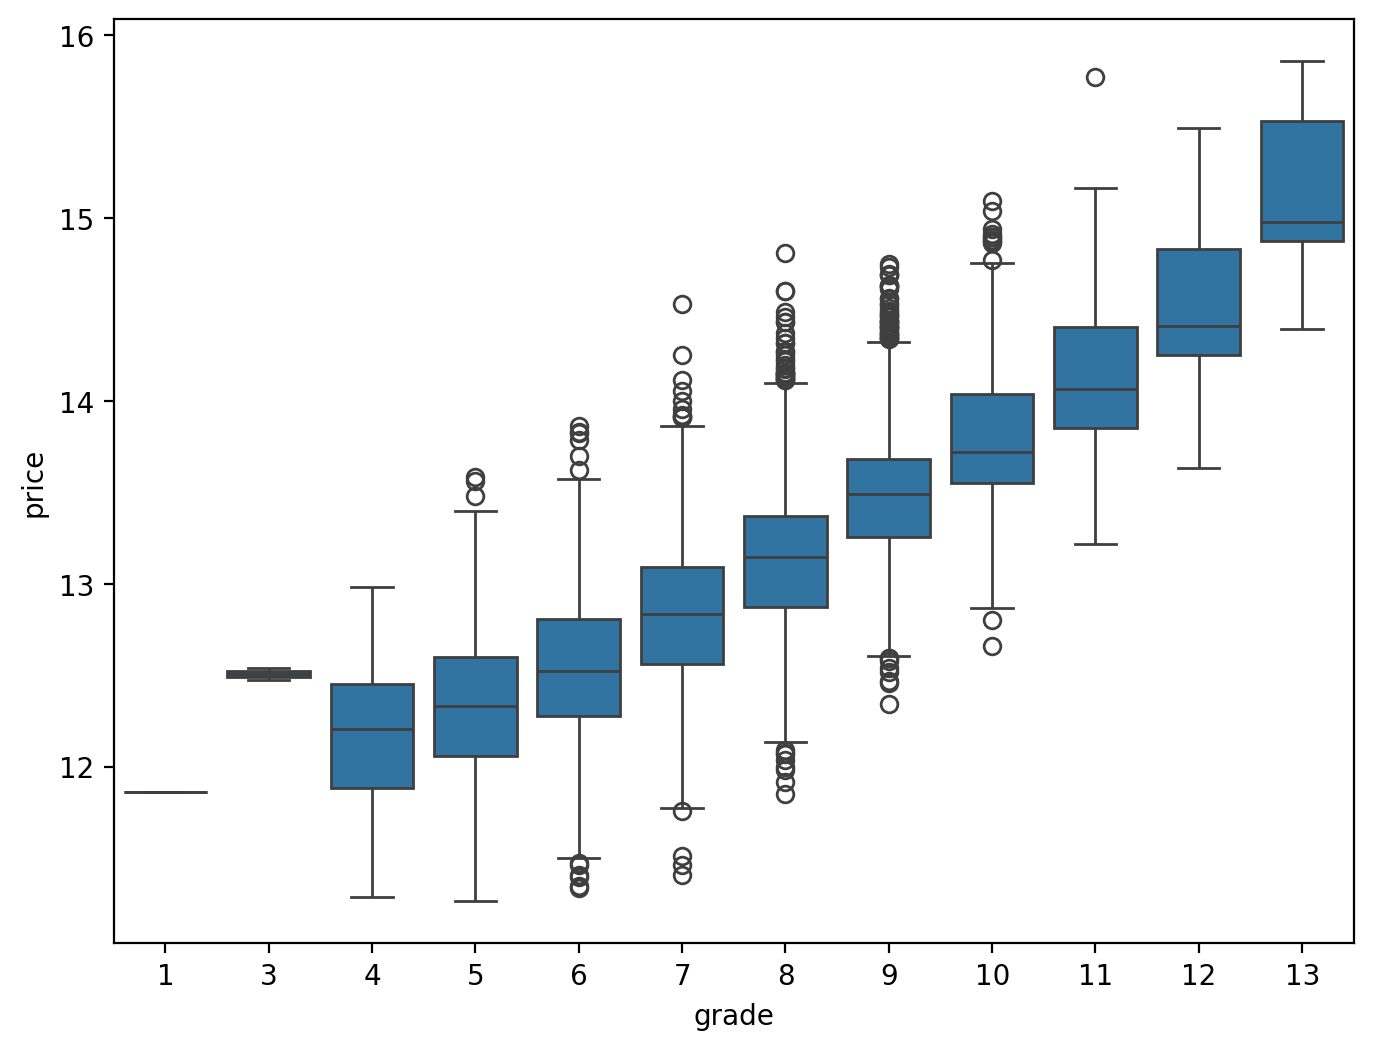

In [22]:
data = pd.concat([train_df['price'], train_df['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [23]:
train_df.loc[(train_df['price'] > 12) & (train_df['grade'] == 3)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,1920.0,98022,47.2082,-121.995,1340,12233
4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,1950.0,98045,47.5316,-121.749,990,22549


In [24]:
train_df.drop([2302,4123], axis=0, inplace=True)

In [25]:
train_df.loc[(train_df['price'] > 14.5) & (train_df['grade'] == 7)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,201501,14.533351,4,3.25,3580,19989,1.5,1,4,4,7,3480,100,1915,1965.0,98125,47.7087,-122.276,2410,6389


In [26]:
train_df.drop(12346, axis=0, inplace=True)

In [27]:
train_df.loc[(train_df['price'] > 14.7) & (train_df['grade'] == 8)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,201408,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985.0,98033,47.6803,-122.214,2660,27295


In [28]:
train_df.drop(7173, axis=0, inplace=True)

In [29]:
train_df.loc[(train_df['price'] > 15.5) & (train_df['grade'] == 11)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001.0,98004,47.65,-122.214,3930,25449


In [30]:
train_df.drop(2775, axis=0, inplace=True)

Normalize

In [31]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_basement', 'sqft_lot15', 'sqft_living15']

In [32]:
for c in skew_columns:
    train_df[c] = np.log1p(train_df[c].values)
    test_df[c] = np.log1p(test_df[c].values)

feature 생성

In [33]:
for df in [train_df, test_df]:
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    # 방의 전체 갯수
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    # 거실의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    # 면적 대비 거실의 비율
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15']
    # 재건축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

아래는 집값 같은 경우는 비슷한 지역에 영향을 받아서 그것을 코드로 구현한 것 입니다. 주의해야 할 점은 단순 집값이 아니라 평당 가격을 써야 한다는 점 입니다 !!!

In [34]:
train_df['per_price'] = train_df['price']/train_df['sqft_total_size']
zipcode_price = train_df.groupby(['zipcode'])['per_price'].agg({
    'mean', 'var'}).reset_index()
del train_df['per_price']
train_df = pd.merge(train_df, zipcode_price, how='left', on='zipcode')
test_df = pd.merge(test_df, zipcode_price, how='left', on='zipcode')

for df in [train_df, test_df]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']
    del df['var']

데이터셋 나누기

In [35]:
y = train_df['price']
del train_df['price']
X = train_df
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(12023, 27) (3006, 27)
(12023,) (3006,)


모델링

In [36]:
from scipy.stats import randint, uniform

param_lgbm = {
    'n_estimators': randint(50, 500),           # 트리 개수
    'learning_rate': uniform(0.01, 0.1),        # 학습률
    'max_depth': randint(3, 15),                # 트리 최대 깊이
}
param_xgb = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 15),
}
param_rf = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 15),
}

In [37]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

lgbm_model = LGBMRegressor(random_state=random_state, force_col_wise=True)
xgb_model = XGBRegressor(random_state=random_state)
rf_model = RandomForestRegressor(random_state=random_state)

# LightGBM 랜덤 서치
lgbm_random_search = RandomizedSearchCV(lgbm_model, param_distributions=param_lgbm,
                                        n_iter=30, cv=5, scoring='neg_mean_squared_error', random_state=random_state, n_jobs=-1)
lgbm_random_search.fit(X_train, y_train)

# XGBoost 랜덤 서치
xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=param_xgb,
                                       n_iter=30, cv=5, scoring='neg_mean_squared_error', random_state=random_state, n_jobs=-1)
xgb_random_search.fit(X_train, y_train)

# Random Forest 랜덤 서치
rf_random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_rf, n_iter=30, cv=5, scoring='neg_mean_squared_error', random_state=random_state, n_jobs=-1)
rf_random_search.fit(X_train, y_train)

# 최적의 파라미터 저장
best_param = {
    'LGBMRegressor': lgbm_random_search.best_params_,
    'XGBRegressor': xgb_random_search.best_params_,
    'RandomForestRegressor': rf_random_search.best_params_
}

[LightGBM] [Info] Total Bins 3923
[LightGBM] [Info] Number of data points in the train set: 9619, number of used features: 27
[LightGBM] [Info] Start training from score 13.046966
[LightGBM] [Info] Total Bins 3929
[LightGBM] [Info] Number of data points in the train set: 9618, number of used features: 27
[LightGBM] [Info] Start training from score 13.043624
[LightGBM] [Info] Total Bins 3923
[LightGBM] [Info] Number of data points in the train set: 9619, number of used features: 27
[LightGBM] [Info] Start training from score 13.046966
[LightGBM] [Info] Total Bins 3923
[LightGBM] [Info] Total Bins 3929
[LightGBM] [Info] Number of data points in the train set: 9619, number of used features: 27
[LightGBM] [Info] Number of data points in the train set: 9618, number of used features: 27
[LightGBM] [Info] Start training from score 13.044280
[LightGBM] [Info] Start training from score 13.043624
[LightGBM] [Info] Total Bins 3925
[LightGBM] [Info] Number of data points in the train set: 9618, nu

In [38]:
# 모델 리스트 초기화 및 학습
models = [
    {'model': LGBMRegressor(
        **best_param['LGBMRegressor'], random_state=random_state), 'name': 'LightGBM'},
    {'model': XGBRegressor(
        **best_param['XGBRegressor'], random_state=random_state), 'name': 'XGBoost'},
    {'model': RandomForestRegressor(
        **best_param['RandomForestRegressor'], random_state=random_state), 'name': 'RandomForest'}
]

In [39]:
from sklearn.metrics import mean_squared_error
for m in models:
    m['model'].fit(X_train, y_train)  # 모델 학습
# 각 모델의 예측값을 열 방향으로 쌓기
preds = np.column_stack([m['model'].predict(X_test) for m in models])
for i in range(3):
    print(f'RMSE : {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(preds[:,i])))}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3937
[LightGBM] [Info] Number of data points in the train set: 12023, number of used features: 27
[LightGBM] [Info] Start training from score 13.044831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE : 111821.73412214794
RMSE : 112238.83328231018
RMSE : 131250.1794272498


In [40]:
for m in models:
    m['model'].fit(train_df.values, y)  # 모델 학습

# 각 모델의 예측값을 열 방향으로 쌓기
preds = np.column_stack([m['model'].predict(test_df.values) for m in models])
# 가중치를 준 앙상블 예측값 생성
pred = 0.5 * preds[:,0] + 0.4 * preds[:,1] + 0.1 * preds[:,2]
# 지수 변환 (로그 스케일을 원래 값으로 변환)
pred = np.expm1(pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3975
[LightGBM] [Info] Number of data points in the train set: 15029, number of used features: 27
[LightGBM] [Info] Start training from score 13.047691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [41]:
# 제출 파일 생성
submission_path = './data/sample_submission.csv'
submission = pd.read_csv(submission_path)
submission['price'] = pred
submission_csv_path = './data/submission.csv'
submission.to_csv(submission_csv_path, index=False)